In [1]:
import os
import time
import numpy as np
import pandas as pd
import nltk
import string
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from nltk.stem.snowball import EnglishStemmer
from clustering import *

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\__init__.py:29: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


Random State is 42 by default, you can change it in the functions parameters.
Functions still in build : ACP, Hierarchical Clustering, allClustering. Do not use it


In [2]:
data = pd.read_csv("data/flipkart_com-ecommerce_sample_1050.csv")
data = data.set_index('uniq_id')

In [3]:
data.head()

,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
uniq_id,,,,,,,,,,,,,,
55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [4]:
from functions import *
isnan(data)

La colonne 'retail_price' comporte 1 / 1050 valeur(s) manquante(s)
Ce qui représente 0.09523809523809523%
La colonne 'discounted_price' comporte 1 / 1050 valeur(s) manquante(s)
Ce qui représente 0.09523809523809523%
La colonne 'brand' comporte 338 / 1050 valeur(s) manquante(s)
Ce qui représente 32.19047619047619%
La colonne 'product_specifications' comporte 1 / 1050 valeur(s) manquante(s)
Ce qui représente 0.09523809523809523%
4 colonnes au total possèdent des valeurs manquantes
85.25 / 1050 valeurs sont manquantes en moyenne dans chaque colonne


# Categories

In [5]:
# We first need to extract the categories from the data
data['categ'] = data['product_category_tree'].str.split(pat='>>').str[0]
data['categ'] = data['categ'].str.split(pat='"').str[1]
# Let's get the second categ, we'll see if we need it later
data['categ2'] = data['product_category_tree'].str.split(pat='>>').str[1]

In [6]:
data['product_category_tree'][0]

'["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]'

In [7]:
len(data['categ'].unique())

7

In [8]:
len(data['categ2'].unique())

63

In [9]:
len(data)

1050

In [10]:
count_categ = data.groupby('categ').count()['pid'] # Take whatever column to count
count_categ

categ
Baby Care                      150
Beauty and Personal Care       150
Computers                      150
Home Decor & Festive Needs     150
Home Furnishing                150
Kitchen & Dining               150
Watches                        150
Name: pid, dtype: int64

# Products

In [11]:
len(data['product_name'].unique())

1050

# Description analysis

## Normalisation

In [12]:
data_text = data.reset_index()
data_text = data_text[['categ', 'description']]
# We take one line per category and sum the description
data_text = data_text.groupby('categ').sum()

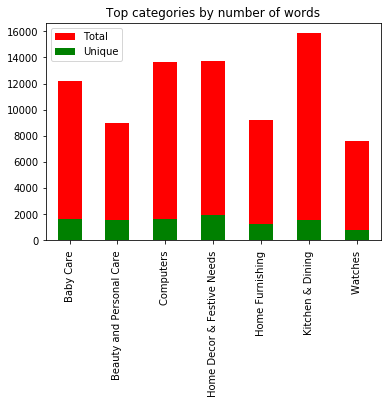

In [13]:
# The goal here is to extract the frequences of the words
# And also to extract the frequences of unique words
tokenizer = nltk.RegexpTokenizer(r'\w+')

desc = defaultdict(list)

for i in data_text.index:
    desc[i] += tokenizer.tokenize(data_text.loc[i, 'description'].lower())

stats, freq = dict(), dict()

for k, v in zip(desc.keys(), desc.values()):
    freq[k] = fq = nltk.FreqDist(v)
    stats[k] = {'total': len(v), 'Unique': len(fq.keys())} 

df = pd.DataFrame.from_dict(stats, orient='index')

# freq display
df.sort_values(by='total', ascending=False)
df['total'].plot(kind='bar', color="red", title='Top categories by number of words', label='Total')
df['Unique'].plot(kind='bar', color="green", label='Unique')
plt.legend()
plt.show()

## Stop words

Let's work on the stop words ; We will create our own set of stop words and then add a common list to that

In [14]:
# First we get the freq of words on our dataset
freq_totale = nltk.Counter()
for k, v in zip(desc.keys(), desc.values()):
    freq_totale += freq[k]

# Here is our list of stop words
most_freq = { key:value for (key,value) in freq_totale.items() if value >= 100}.keys()

# Let's add the common stop words list of nltk
sw = set()
sw.update(most_freq)
sw.update(tuple(nltk.corpus.stopwords.words('english')))
sw.update(tuple(['!', '?', '.', ';', '"', "'", "#",
                 "&", "/", "-", "_", "'m",
                 "%", "*", "(", ")", "±3",
                 ",", "'s", '“', '”']))

Let's plot again our words repartition but without the stop words this time

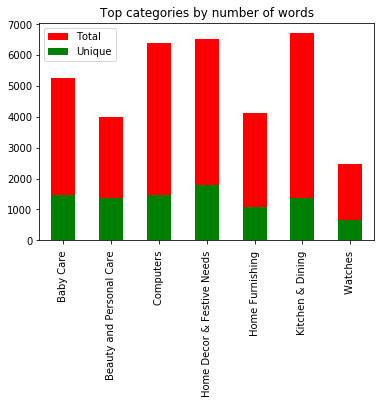

In [15]:
tokenizer = nltk.RegexpTokenizer(r'\w+')

desc = defaultdict(list)

for i in data_text.index:
    token = tokenizer.tokenize(data_text.loc[i, 'description'].lower())
    desc[i] += [w for w in token if not w in list(sw)]

stats, freq = dict(), dict()

for k, v in zip(desc.keys(), desc.values()):
    freq[k] = fq = nltk.FreqDist(v)
    stats[k] = {'total': len(v), 'Unique': len(fq.keys())} 

df = pd.DataFrame.from_dict(stats, orient='index')

# freq display
df.sort_values(by='total', ascending=False)
df['total'].plot(kind='bar', color="red", title='Top categories by number of words', label='Total')
df['Unique'].plot(kind='bar', color="green", label='Unique')
plt.legend()
plt.show()

## Stemming

We take our code back and just add the stemmer in it

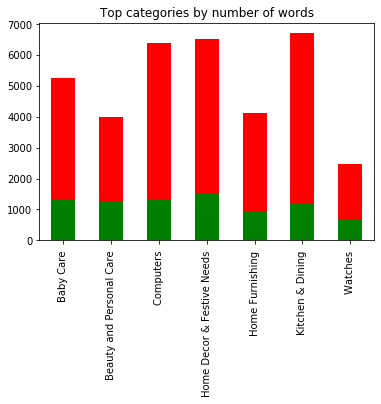

In [16]:
stemmer = EnglishStemmer()

tokenizer = nltk.RegexpTokenizer(r'\w+')

desc = defaultdict(list)

for i in data_text.index:
    token = tokenizer.tokenize(data_text.loc[i, 'description'].lower())
    desc[i] += [stemmer.stem(w) for w in token if not w in list(sw)]

stats, freq = dict(), dict()

for k, v in zip(desc.keys(), desc.values()):
    freq[k] = fq = nltk.FreqDist(v)
    stats[k] = {'total': len(v), 'Unique': len(fq.keys())}

df = pd.DataFrame.from_dict(stats, orient='index')

# freq display
df.sort_values(by='total', ascending=False)
df['total'].plot(kind='bar', color="red", title='Top categories by number of words', label='Total')
df['Unique'].plot(kind='bar', color="green", label='Unique')
plt.show()

## TF-IDF

In [17]:
data_tf = data.reset_index()[['uniq_id', 'categ', 'product_name', 'description']]

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return stems

token_dict = defaultdict(list)

for i in range(0, len(data_tf)):
    lowers = data_tf.loc[i,'description'].lower()
    no_punctuation = lowers.translate(string.punctuation)
    token_dict[i] = no_punctuation

tfIdf = TfidfVectorizer(tokenizer=tokenize, stop_words=sw)
values = tfIdf.fit_transform(token_dict.values())

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", '``', 'abov', 'adapt', 'ani', 'babi', 'batteri', 'becaus', 'befor', 'ceram', 'coffe', 'content', 'could', 'deliveri', 'detail', 'dimens', 'discount', 'doe', 'dure', 'easi', 'featur', 'genuin', 'guarante', 'materi', 'might', 'must', "n't", 'need', 'onc', 'onli', 'onlin', 'ourselv', 'packag', 'qualiti', 'replac', 'sale', 'sha', 'ship', 'showpiec', 'specif', 'themselv', 'veri', 'warranti', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [18]:
values_df = pd.DataFrame(values, index=data_tf.index)
X_embedded = TSNE(n_components=2).fit_transform(values)
X_embedded_df = pd.DataFrame(X_embedded, index=data_tf.index, columns=['V1', 'V2'])

In [19]:
data_tf_plot = pd.merge(data_tf, X_embedded_df,
                        left_index=True,
                        right_index=True,
                        how='inner').set_index('uniq_id')[['categ', 'V1', 'V2']]

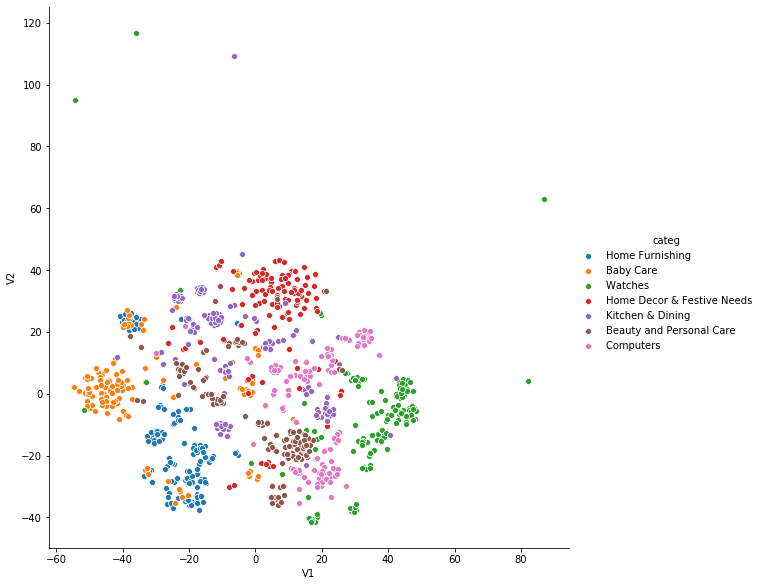

In [20]:
sns.pairplot(x_vars=['V1'], y_vars=['V2'], data=data_tf_plot, hue='categ', height=8)
plt.savefig("Graphiques/TSNE.jpg")
plt.show()

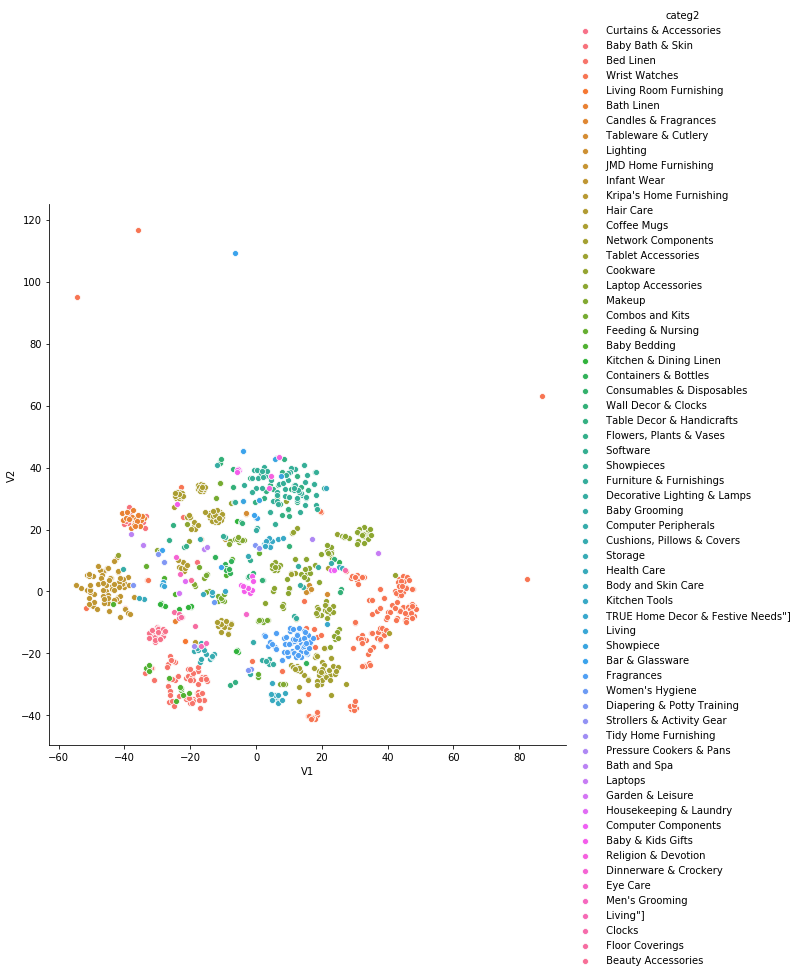

In [21]:
data_tf_plot_2 = pd.merge(data_tf_plot, data[['categ2']],
                          left_index=True, right_index=True, how='left')
sns.pairplot(x_vars=['V1'], y_vars=['V2'], data=data_tf_plot_2, hue='categ2', height=8)
plt.savefig("Graphiques/TSNE_categ2.jpg")
plt.show()

In [22]:
del X_embedded

# Classifier

In [23]:
np.random.seed(42)

## Train & Test

In [24]:
x = data_tf_plot[['V1', 'V2']]
y = data_tf_plot[['categ']]

In [25]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

## Cross-Validation

In [26]:
# Nombre d'arbres dans la forêt
n_estimators = [int(x) for x in np.linspace(start = 1000, stop = 2000, num = 10)]
# Level max des arbres
max_depth = [int(x) for x in np.linspace(60, 80, num = 10)]
max_depth.append(None)
# nombre de sample min pour split
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# On crée la random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

t0 = time.perf_counter()

rf = RandomForestClassifier()

# On recherche avec 100 combinaisons différentes 
rf = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, 
                               cv=3, verbose=2, random_state=42, n_jobs=-1)

# On fit
rf.fit(x_train, y_train)

t1 = time.perf_counter()
print("\n")
print ('Function elapsed in: ', t1-t0, 's')

rf.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   50.9s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)




Function elapsed in:  51.9170007 s


{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': 66,
 'bootstrap': True}

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':




Function elapsed in:  0.9783919000000054 s


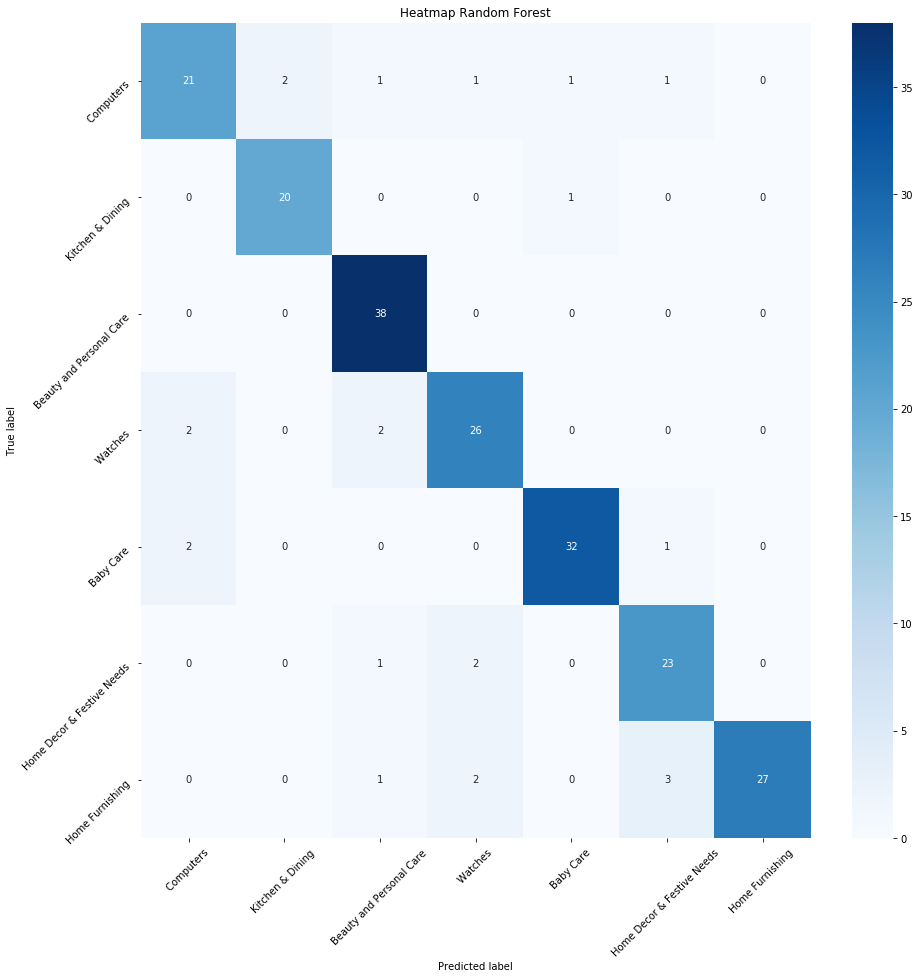

Accuracy: 0.8904761904761904


In [27]:
t0 = time.perf_counter()

rf = RandomForestClassifier(n_estimators = list(rf.best_params_.values())[0],
                             min_samples_split = list(rf.best_params_.values())[1],
                             min_samples_leaf=list(rf.best_params_.values())[2],
                             max_depth = list(rf.best_params_.values())[3],
                             bootstrap=list(rf.best_params_.values())[4],
                             n_jobs = -1)
rf.fit(x_train, y_train)
# on prédit
y_predict = rf.predict(x_test)

t1 = time.perf_counter()
print("\n")
print ('Function elapsed in: ', t1-t0, 's')

y_predict_df = pd.DataFrame(y_predict, index=y_test.index, columns=['Predict'])
accuracy = pd.merge(y_test, y_predict_df, left_index=True, right_index=True, how='inner')

conf_matrix = confusion_matrix(accuracy["categ"], 
                               accuracy['Predict'])

x_label = accuracy["categ"].unique()
y_label = accuracy["categ"].unique()

ax = plt.subplots(figsize=(15,15))
ax = sns.heatmap(conf_matrix, cmap=plt.cm.Blues, annot=True)
ax.set(xticklabels=x_label, yticklabels=y_label,
        title="Heatmap Random Forest",
        ylabel='True label',
        xlabel='Predicted label')
#plt.savefig("Graphiques/heatmap_kmeans")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.savefig("Graphiques/Heatmap_text.jpg")
plt.show()
print('Accuracy:', accuracy_score(y_test, y_predict))

# Images

In [28]:
import cv2

In [29]:
from PIL import Image
from numpy import asarray

## Features extraction for all images

In [30]:
data_images = data[['categ', 'image']]

images = []
for i in data_images.index:
    image = cv2.imread("data/Images/" + data.loc[i, 'image'])
    images.append(image)
images = pd.DataFrame(images, index=data_images.index, columns=['image_array'])

data_images = pd.merge(data_images, images, left_index=True, right_index=True, how='inner')
data_images = data_images.dropna()

In [31]:
#Initialize ORB
orb = cv2.ORB_create(nfeatures=200)

des = pd.DataFrame(columns=[i for i in range(0,32)])
error = []
index = []
# Detect & compute
for i in data_images.index:
    try:
        im = data_images.at[i, 'image_array']
        kp1, des1 = orb.detectAndCompute(im,None)
        if des1 is not None:
            index = [i] * len(des1)
            des1 = pd.DataFrame(des1, index=index)
            des = des.append(des1)
    except AttributeError:
        error.append(i)

In [32]:
data_images = data_images.drop(error)

We now know how much vectors we need to handle before doing the clustering

In [33]:
# The df we're building now we'll be converted into unsigned to avoid memory error
# As it is a really big df
des_df = des.apply(pd.to_numeric,downcast='unsigned')

In [34]:
print(des_df.memory_usage(deep=True).sum()/ 1024 ** 2)
print(des.memory_usage(deep=True).sum()/ 1024 ** 2)

23.777978897094727
243.7354030609131


In [35]:
del images

Clustering on the descriptors

In [36]:
# Let's create a dev sample in order to reduce the time of computation for elbow and silhouette
des_df_dev = des_df.sample(n=50000) # Adapt the nbr of samples according to your machine capabilities

In [37]:
# Scale data
X_scaled = prepData.centrageReduction(des_df_dev)
# Choose the different number of clusters for test
nbr_clust = [50, 100, 200, 300, 400, 500]
# Elbow computation for a first overview
elbow = clustering.elbowMethod(des_df_dev, X_scaled, nbr_clust)

In [38]:
# Nbr of clusters for test
nbr_clust = [100, 200, 300, 400, 500]
# Silouhette computation to see which range of clusters is best
silhouette_coef = clustering.silhouette(des_df_dev, X_scaled, nbr_clust)

In [39]:
del des_df_dev

In [40]:
from sklearn.cluster import MiniBatchKMeans
X_scaled = prepData.centrageReduction(des_df)

# We use kmeans Mini Batch as the number of data is too big to be computed in one time
kmeans = MiniBatchKMeans(n_clusters=70,
                         random_state=42,
                         batch_size=100).fit_predict(X_scaled)
kmeans = pd.DataFrame(kmeans, index=des_df.index, columns=["Clusters"])
data_clust = pd.merge(des_df, kmeans, left_index=True, right_index=True, how='left')
data_clust = data_clust[['Clusters']]

In [41]:
del des_df

In [42]:
# We put the clusters into a list
data_clust = pd.DataFrame(data_clust).reset_index()
data_clust = data_clust.groupby(["index"])["Clusters"].apply(list)
data_clust = data_clust.apply(pd.Series)

# Unstack to get one column with all the clusters
data_clust = data_clust.unstack().reset_index()
data_clust = data_clust.drop(columns=['level_0'])
data_clust = data_clust.rename(columns={'level_0':'index',0:'Clusters'})

In [43]:
# We then transform the clusters into dummy variables,
# So we have a bag of visual words
data_clust = pd.get_dummies(data_clust.set_index('index'), columns=['Clusters'],sparse=True).astype(np.int8)

# Group by with count to get 1 line = 1 image
data_clust = data_clust.reset_index().groupby(["index"]).sum()

In [44]:
data_clust.head()

,Clusters_0.0,Clusters_1.0,Clusters_2.0,Clusters_3.0,Clusters_4.0,Clusters_5.0,Clusters_6.0,Clusters_7.0,Clusters_8.0,Clusters_9.0,...,Clusters_60.0,Clusters_61.0,Clusters_62.0,Clusters_63.0,Clusters_64.0,Clusters_65.0,Clusters_66.0,Clusters_67.0,Clusters_68.0,Clusters_69.0
index,,,,,,,,,,,,,,,,,,,,,
009099b1f6e1e8f893ec29a7023153c4,800,0,600,400,1200,0,4000,0,200,0,...,200,200,0,600,0,400,400,1000,400,1200
0096e89cc25a8b96fb9808716406fe94,400,0,1600,1600,600,0,600,0,800,0,...,0,400,200,600,0,200,0,1400,400,600
00cbbc837d340fa163d11e169fbdb952,179,358,0,1253,0,0,0,358,0,0,...,1253,0,0,0,3222,537,358,0,0,3222
00d84a518e0550612fcfcba3b02b6255,200,3000,0,0,0,200,800,200,7200,1000,...,400,800,3000,0,800,400,800,0,0,200
00e966a5049a262cfc72e6bbf68b80e7,200,1000,0,400,0,1400,0,6400,400,200,...,1800,400,0,0,600,200,600,200,400,200


In [45]:
# We merge the new dataframe with the images df so that we have the clusters and the categ
data_clust_merge = pd.merge(data_clust, data_images[['categ']],
                            left_index=True, right_index=True,
                            how='left')

In [46]:
data_clust_merge.head()

,Clusters_0.0,Clusters_1.0,Clusters_2.0,Clusters_3.0,Clusters_4.0,Clusters_5.0,Clusters_6.0,Clusters_7.0,Clusters_8.0,Clusters_9.0,...,Clusters_61.0,Clusters_62.0,Clusters_63.0,Clusters_64.0,Clusters_65.0,Clusters_66.0,Clusters_67.0,Clusters_68.0,Clusters_69.0,categ
index,,,,,,,,,,,,,,,,,,,,,
009099b1f6e1e8f893ec29a7023153c4,800,0,600,400,1200,0,4000,0,200,0,...,200,0,600,0,400,400,1000,400,1200,Watches
0096e89cc25a8b96fb9808716406fe94,400,0,1600,1600,600,0,600,0,800,0,...,400,200,600,0,200,0,1400,400,600,Kitchen & Dining
00cbbc837d340fa163d11e169fbdb952,179,358,0,1253,0,0,0,358,0,0,...,0,0,0,3222,537,358,0,0,3222,Home Furnishing
00d84a518e0550612fcfcba3b02b6255,200,3000,0,0,0,200,800,200,7200,1000,...,800,3000,0,800,400,800,0,0,200,Beauty and Personal Care
00e966a5049a262cfc72e6bbf68b80e7,200,1000,0,400,0,1400,0,6400,400,200,...,400,0,0,600,200,600,200,400,200,Computers


In [47]:
x = np.asarray(data_clust_merge.iloc[:,0:-1]) # All the clusters
y = data_clust_merge.iloc[:,-1] # Only the categ

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [48]:
# Nombre d'arbres dans la forêt
n_estimators = [int(x) for x in np.linspace(start = 800, stop = 1600, num = 10)]
# Level max des arbres
max_depth = [int(x) for x in np.linspace(60, 100, num = 5)]
max_depth.append(None)
# nombre de sample min pour split
min_samples_split = [5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# On crée la random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

t0 = time.perf_counter()

rf = RandomForestClassifier()

# On recherche avec 100 combinaisons différentes 
rf = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=50, 
                               cv=3, verbose=2, random_state=42, n_jobs=-1)

# On fit
rf.fit(x_train, y_train)

t1 = time.perf_counter()
print("\n")
print ('Function elapsed in: ', t1-t0, 's')

rf.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   35.5s finished




Function elapsed in:  39.37154559999908 s


{'n_estimators': 1511,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_depth': 80,
 'bootstrap': False}



Function elapsed in:  1.4020068000008905 s


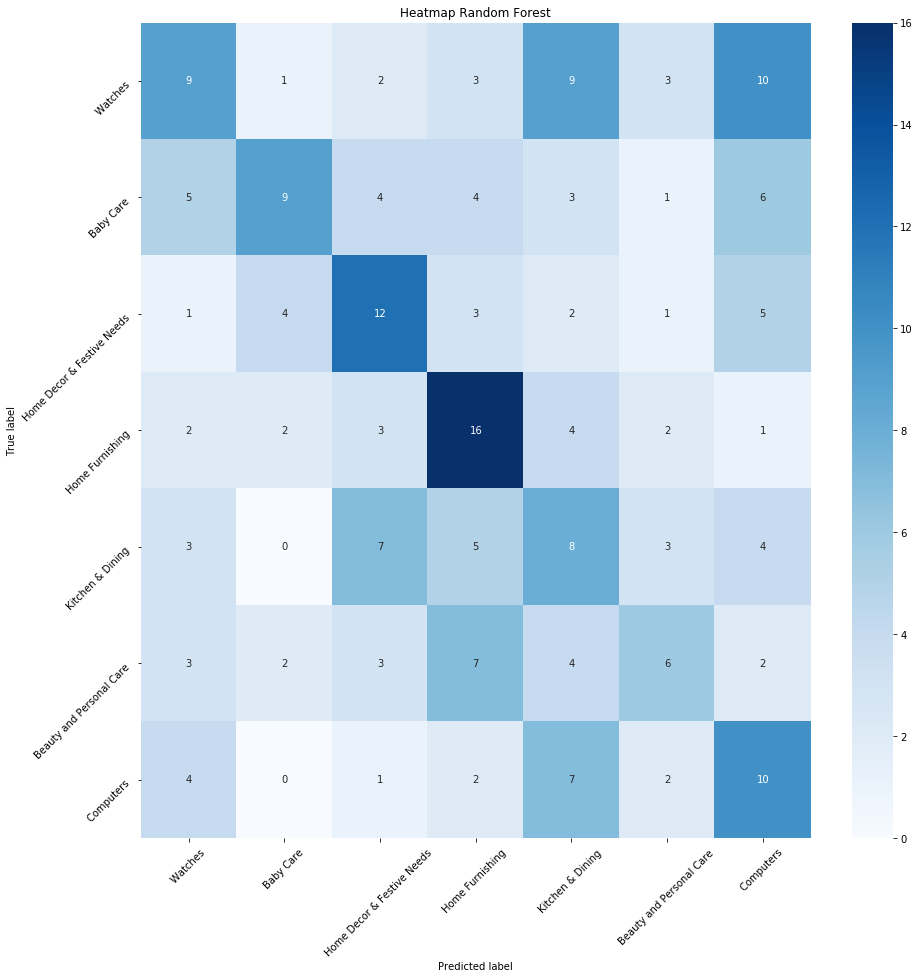

Accuracy: 0.3333333333333333


In [49]:
t0 = time.perf_counter()

rf_ = RandomForestClassifier(n_estimators = list(rf.best_params_.values())[0],
                             min_samples_split = list(rf.best_params_.values())[1],
                             min_samples_leaf=list(rf.best_params_.values())[2],
                             max_depth = list(rf.best_params_.values())[3],
                             bootstrap=list(rf.best_params_.values())[4],
                             n_jobs = -1)
rf_.fit(x_train, y_train)
# on prédit
y_predict = rf_.predict(x_test)

t1 = time.perf_counter()
print("\n")
print ('Function elapsed in: ', t1-t0, 's')

y_predict_df = pd.DataFrame(y_predict, index=y_test.index, columns=['Predict'])
accuracy = pd.merge(y_test, y_predict_df, left_index=True, right_index=True, how='inner')

conf_matrix = confusion_matrix(accuracy["categ"], 
                               accuracy['Predict'])

x_label = accuracy["categ"].unique()
y_label = accuracy["categ"].unique()

ax = plt.subplots(figsize=(15,15))
ax = sns.heatmap(conf_matrix, cmap=plt.cm.Blues, annot=True)
ax.set(xticklabels=x_label, yticklabels=y_label,
        title="Heatmap Random Forest",
        ylabel='True label',
        xlabel='Predicted label')
#plt.savefig("Graphiques/heatmap_kmeans")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()
print('Accuracy:', accuracy_score(y_test, y_predict))

As expected, the results are not well <br/>
We will try with a neural network in another notebook to see if we get better results

# Combined text and images

We will now build a pipeline to combine the text analysis and the images analysis in order to get a more powerfull model (or not, we'll see that)

## Set up DataFrame

In [50]:
data_pipeline = pd.merge(data_clust, data_tf_plot, left_index=True,
                         right_index=True, how='inner')

x = data_pipeline.drop(columns=['categ'])
y = data_pipeline[['categ']]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# Prendre TF-IDF et pas TSNE

In [51]:
x.shape

(1049, 72)

## PCA

In [52]:
from functions2 import *
from sklearn import preprocessing, decomposition

In [53]:
#Choix du nombre de composantes à calculer : 
n_comp = 72

# Selection des colonnes à prendre en compte dans l'ACP : 
data_pca = x.copy()

#Import des clusters : 
#clusters = [echantillon.loc[pays, "Clusters"] for pays in echantillon.index]

#Préparation des données pour l'ACP :
data_pca = data_pca.fillna(data_pca.mean()) #On remplace les valeurs inconnues par la moyenne de la variable

X = data_pca.values #On ne prend que les valeurs

names = data_pca.index

features = data_pca.columns

#Centrage et réduction : 
std_scale = preprocessing.StandardScaler().fit(X) #On centre
X_scaled = std_scale.transform(X) #On réduit

#Calcul des composantes principales 
pca = decomposition.PCA(n_components = n_comp)
pca = pca.fit(X_scaled)

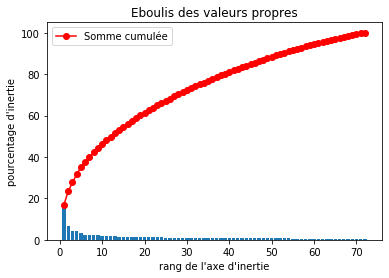

In [54]:
display_scree_plot(pca)

PCA is not very usefull here, let's try a random forest without the PCA first

## Clustering

In [55]:
# Let's try with a simple kmeans with 7 clusters
X_scaled = prepData.centrageReduction(data_pipeline.drop(columns=['categ']))
data_clust_pipeline = clustering.makeClustering(data_pipeline.drop(columns=['categ']), X_scaled, 7)
data_clust_pipeline = data_clust_pipeline[['Clusters']]

In [56]:
# Let's transform the categ into numbers
categ_number = data_pipeline[['categ']]
categ_number.loc[:,'categ'] = pd.Categorical(data_pipeline.categ)
categ_number.loc[:,'categ_number'] = np.int32(categ_number.categ.cat.codes)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

In [57]:
data_clust_pipeline_ = pd.merge(data_clust_pipeline, categ_number,
                                left_index=True, right_index=True,
                                how='inner')

In [58]:
data_grouped = data_clust_pipeline_.groupby(['Clusters', 'categ']).count()
# .agg(lambda x:x.value_counts().index[0])
data_grouped

categ_number
Clusters categ                                    
0        Baby Care                              13
         Beauty and Personal Care               46
         Computers                              15
         Home Decor & Festive Needs             44
         Home Furnishing                        22
         Kitchen & Dining                       17
         Watches                                15
1        Baby Care                              28
         Beauty and Personal Care               12
         Computers                              23
         Home Decor & Festive Needs              8
         Home Furnishing                        10
         Kitchen & Dining                       21
         Watches                                17
2        Baby Care                              36
         Beauty and Personal Care               26
         Computers                              16
         Home Decor & Festive Needs             31
         Home Furnishing                        49
         Kitchen & Dining                       40
         Watches                                19
3        Baby Care                              14
         Beauty and Personal Care               15
         Computers                              21
         Home Decor & Festive Needs             28
         Home Furnishing                        30
         Kitchen & Dining                       21
         Watches                                12
4        Baby Care                              37
         Beauty and Personal Care               29
         Computers                              24
         Home Decor & Festive Needs             12
         Home Furnishing                        20
         Kitchen & Dining                       25
         Watches                                56
5        Baby Care                              15
         Beauty and Personal Care                5
         Computers                              28
         Home Decor & Festive Needs              7
         Home Furnishing                        13
         Kitchen & Dining                       19
         Watches                                11
6        Baby Care                               7
         Beauty and Personal Care               17
         Computers                              22
         Home Decor & Festive Needs             20
         Home Furnishing                         6
         Kitchen & Dining                        7
         Watches                                20

It looks like we have the following for the clusters : <br/>
<ul><li>Cluster 0: Home Furnishing</li>
    <li>Cluster 1: Beauty and Personal Care</li>
    <li>Cluster 2: Watches</li>
    <li>Cluster 3: Kitchen & Dining (This cluster is messy, but this is the only categ that is not taken with the others clusters)</li>
    <li>Cluster 4: Baby Care</li>
    <li>Cluster 5: Computers</li>
    <li>Cluster 6: Home Decor & Festive Needs</li>

</ul>

Let's replace the clusters with the true categ

In [59]:
data_clust_pipeline_.categ.unique()

[Watches, Kitchen & Dining, Home Furnishing, Beauty and Personal Care, Computers, Home Decor & Festive Needs, Baby Care]
Categories (7, object): [Watches, Kitchen & Dining, Home Furnishing, Beauty and Personal Care, Computers, Home Decor & Festive Needs, Baby Care]

In [60]:
toReplace = {0:'Home Furnishing ', 1:'Beauty and Personal Care ', 2:'Watches ',
             3:'Kitchen & Dining ', 4:'Baby Care ', 5:'Computers ', 6:'Home Decor & Festive Needs '}

data_clust_pipeline_ = data_clust_pipeline_.copy()

data_clust_pipeline_['Clusters'] = data_clust_pipeline_['Clusters'].replace(toReplace)
data_clust_pipeline_['Clusters'] = pd.Categorical(data_clust_pipeline_.Clusters)
# data_clust_pipeline_['categ'] = data_clust_pipeline_['categ'].astype(str)
# data_clust_pipeline_['Clusters'] = data_clust_pipeline_['Clusters'].astype(str)

In [61]:
data_clust_pipeline_.head()

,Clusters,categ,categ_number
009099b1f6e1e8f893ec29a7023153c4,Home Decor & Festive Needs,Watches,6
0096e89cc25a8b96fb9808716406fe94,Home Furnishing,Kitchen & Dining,5
00cbbc837d340fa163d11e169fbdb952,Baby Care,Home Furnishing,4
00d84a518e0550612fcfcba3b02b6255,Beauty and Personal Care,Beauty and Personal Care,1
00e966a5049a262cfc72e6bbf68b80e7,Baby Care,Computers,2


In [62]:
data_clust_pipeline_.dtypes

Clusters        category
categ           category
categ_number       int32
dtype: object

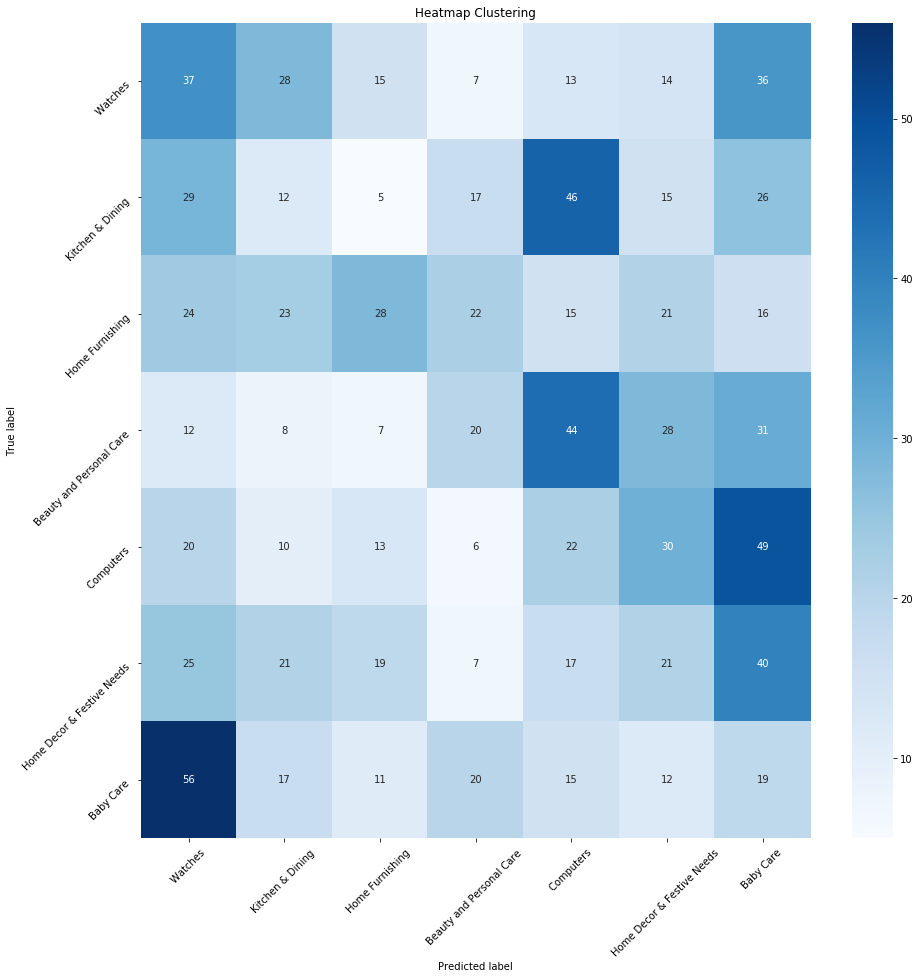

Accuracy: 0.1515729265967588


In [63]:
conf_matrix = confusion_matrix(data_clust_pipeline_["categ"], 
                               data_clust_pipeline_['Clusters'])

x_label = data_clust_pipeline_["categ"].unique()
y_label = data_clust_pipeline_["categ"].unique()

ax = plt.subplots(figsize=(15,15))
ax = sns.heatmap(conf_matrix, cmap=plt.cm.Blues, annot=True)
ax.set(xticklabels=x_label, yticklabels=y_label,
        title="Heatmap Clustering",
        ylabel='True label',
        xlabel='Predicted label')
#plt.savefig("Graphiques/heatmap_kmeans")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()
print('Accuracy:', accuracy_score(data_clust_pipeline_["categ"], data_clust_pipeline_['Clusters']))

Unsupervised learning does not seem to be the good solution here, as the accuracy is really low. We'll try with a simple classifier to see the results

## Classifier

In [64]:
# Nombre d'arbres dans la forêt
n_estimators = [int(x) for x in np.linspace(start = 800, stop = 1600, num = 10)]
# Level max des arbres
max_depth = [int(x) for x in np.linspace(60, 100, num = 5)]
max_depth.append(None)
# nombre de sample min pour split
min_samples_split = [5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# On crée la random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

t0 = time.perf_counter()

rf = RandomForestClassifier()

# On recherche avec 100 combinaisons différentes 
rf = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=50, 
                               cv=3, verbose=2, random_state=42, n_jobs=-1)

# On fit
rf.fit(x_train, y_train)

t1 = time.perf_counter()
print("\n")
print ('Function elapsed in: ', t1-t0, 's')

rf.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   32.7s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)




Function elapsed in:  35.75261450000107 s


{'n_estimators': 1155,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_depth': 100,
 'bootstrap': False}

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':




Function elapsed in:  1.1272288000000117 s


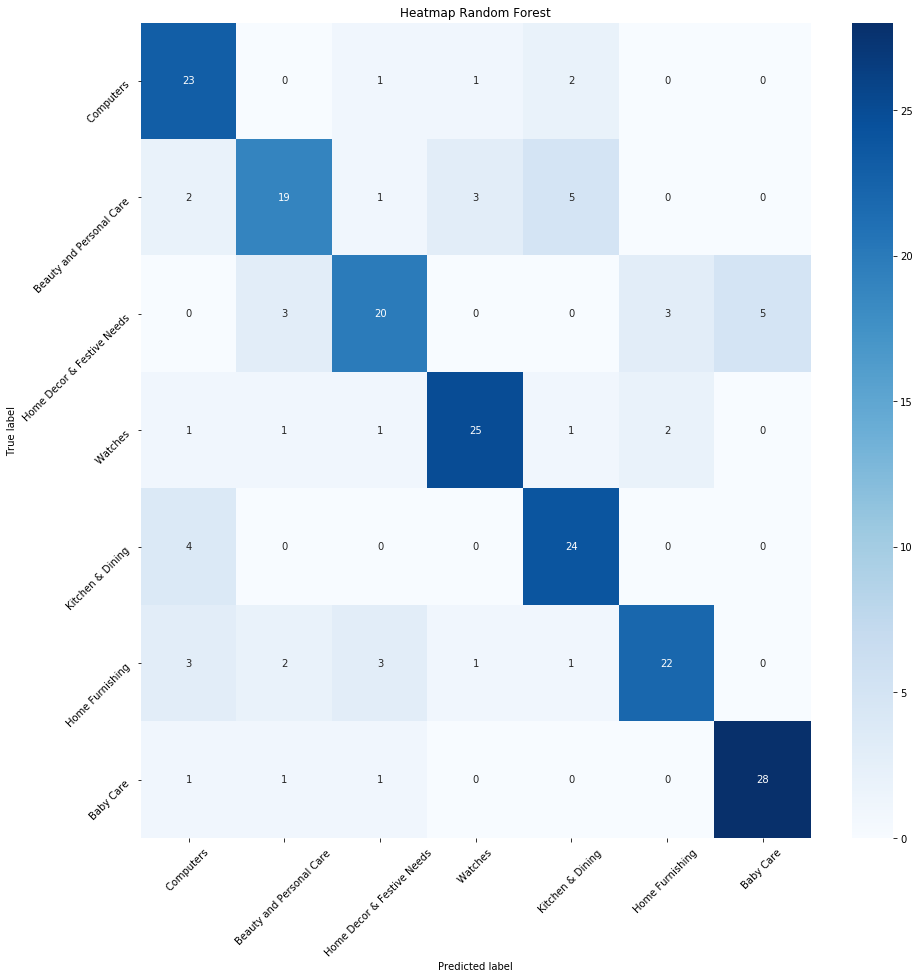

Accuracy: 0.7666666666666667


In [65]:
t0 = time.perf_counter()

rf_ = RandomForestClassifier(n_estimators = list(rf.best_params_.values())[0],
                             min_samples_split = list(rf.best_params_.values())[1],
                             min_samples_leaf=list(rf.best_params_.values())[2],
                             max_depth = list(rf.best_params_.values())[3],
                             bootstrap=list(rf.best_params_.values())[4],
                             n_jobs = -1)
rf_.fit(x_train, y_train)
# on prédit
y_predict = rf_.predict(x_test)

t1 = time.perf_counter()
print("\n")
print ('Function elapsed in: ', t1-t0, 's')

y_predict_df = pd.DataFrame(y_predict, index=y_test.index, columns=['Predict'])
accuracy = pd.merge(y_test, y_predict_df, left_index=True, right_index=True, how='inner')

conf_matrix = confusion_matrix(accuracy["categ"], 
                               accuracy['Predict'])

x_label = accuracy["categ"].unique()
y_label = accuracy["categ"].unique()

ax = plt.subplots(figsize=(15,15))
ax = sns.heatmap(conf_matrix, cmap=plt.cm.Blues, annot=True)
ax.set(xticklabels=x_label, yticklabels=y_label,
        title="Heatmap Random Forest",
        ylabel='True label',
        xlabel='Predicted label')
#plt.savefig("Graphiques/heatmap_kmeans")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()
print('Accuracy:', accuracy_score(y_test, y_predict))

There is an improvement with the "pictures only" model <br/>
Still, the pipeline is at 0.81 and the text only at 0.90 <br/>
Meaning we will only take the text for the classifier at this point